In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('amz_uk_price_prediction_dataset.csv.zip')

In [3]:
df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [4]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]

In [16]:
df.shape

(2443651, 9)

## Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:

> Create a crosstab between the product category and the isBestSeller status.

> Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

Statistical Tests:

> Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

> Compute Cramér's V to understand the strength of association between best-seller status and category.

Visualizations:

> Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [5]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
crosstab_result.dtypes

isBestSeller
False    int64
True     int64
dtype: object

In [17]:
proportion_crosstab = crosstab_result[True] / (crosstab_result[True] + crosstab_result[False])
proportion_crosstab

category
3D Printers                       0.004032
3D Printing & Scanning            0.000492
Abrasive & Finishing Products     0.020000
Action Cameras                    0.000589
Adapters                          0.011811
                                    ...   
Wind Instruments                  0.028000
Window Treatments                 0.020921
Women                             0.011985
Women's Sports & Outdoor Shoes    0.010209
eBook Readers & Accessories       0.000000
Length: 296, dtype: float64

In [18]:
proportion_crosstab = crosstab_result.div(crosstab_result.sum(axis=1), axis=0)
proportion_crosstab

isBestSeller,False,True
category,,
3D Printers,0.995968,0.004032
3D Printing & Scanning,0.999508,0.000492
Abrasive & Finishing Products,0.980000,0.020000
Action Cameras,0.999411,0.000589
Adapters,0.988189,0.011811
...,...,...
Wind Instruments,0.972000,0.028000
Window Treatments,0.979079,0.020921
Women,0.988015,0.011985


In [8]:
#Being best seller is not prevalent

In [9]:
from scipy.stats import chi2_contingency

# Chi-square test for 'isBestSeller' and 'category'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [10]:
#There is a significant association between the categorical variables

In [11]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

<Axes: xlabel='category'>

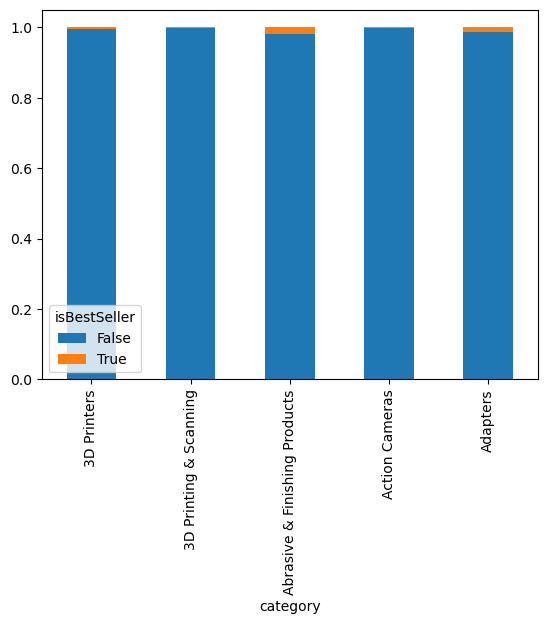

In [20]:
# Plotting a stacked bar chart for the 'crosstab_result' data
proportion_crosstab.head().plot(kind="bar", stacked=True)

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

Violin Plots:

> Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.

Bar Charts:

> Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

Box Plots:

> Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [13]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

df_no_outliers

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


/var/folders/jg/z9vz0kpj1t56r_y5t2ghwzxc0000gn/T/ipykernel_61635/3553319126.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='price', y='category', palette="coolwarm", legend = True);


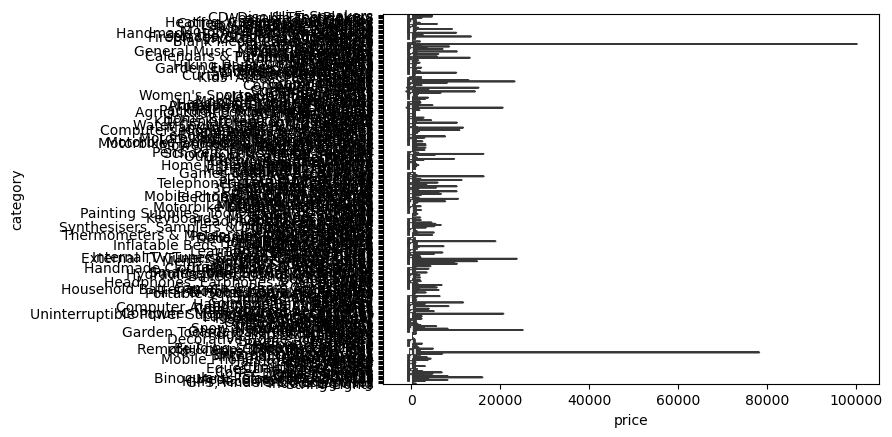

In [29]:
sns.violinplot(data=df, x='price', y='category', palette="coolwarm", legend = True);

/var/folders/jg/z9vz0kpj1t56r_y5t2ghwzxc0000gn/T/ipykernel_61635/3915807832.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_20, x='price', y='category', palette="coolwarm", legend = True)


<Axes: xlabel='price', ylabel='category'>

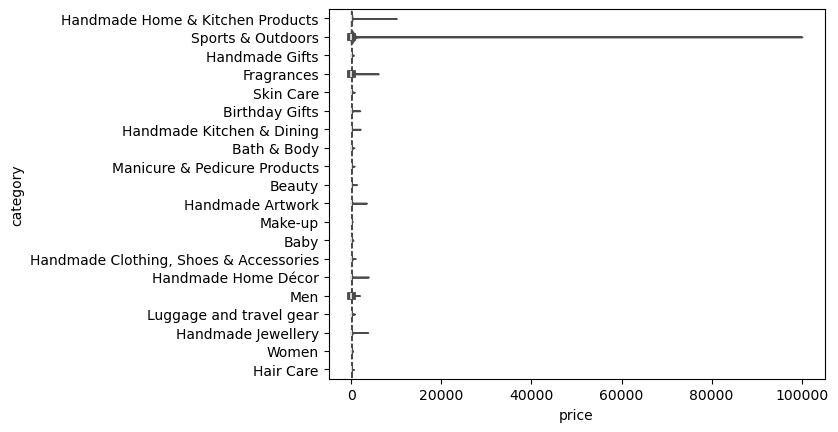

In [31]:
top_20_categories = df['category'].value_counts().head(20).index

df_top_20 = df[df['category'].isin(top_20_categories)]

sns.violinplot(data=df_top_20, x='price', y='category', palette="coolwarm", legend = True)

In [35]:
#Which product category tends to have the highest median price?

median_prices = df.groupby('category')['price'].median().sort_values(ascending=False)

print(median_prices)

highest_median_price_category = median_prices.idxmax()
highest_median_price_value = median_prices.max()

print(f'Category with highest median: ', highest_median_price_category, highest_median_price_value)

category
Laptops                      1042.725
Desktop PCs                   810.400
Snowboards                    366.725
Home Audio Record Players     326.080
3D Printers                   319.000
                               ...   
Adapters                        7.050
Make-up                         7.000
Signs & Plaques                 6.990
Arts & Crafts                   5.990
Office Paper Products           4.380
Name: price, Length: 296, dtype: float64
Category with highest median:  Laptops 1042.725


/var/folders/jg/z9vz0kpj1t56r_y5t2ghwzxc0000gn/T/ipykernel_61635/1170870571.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_prices, x='price', y='category', palette="coolwarm")


<Axes: xlabel='price', ylabel='category'>

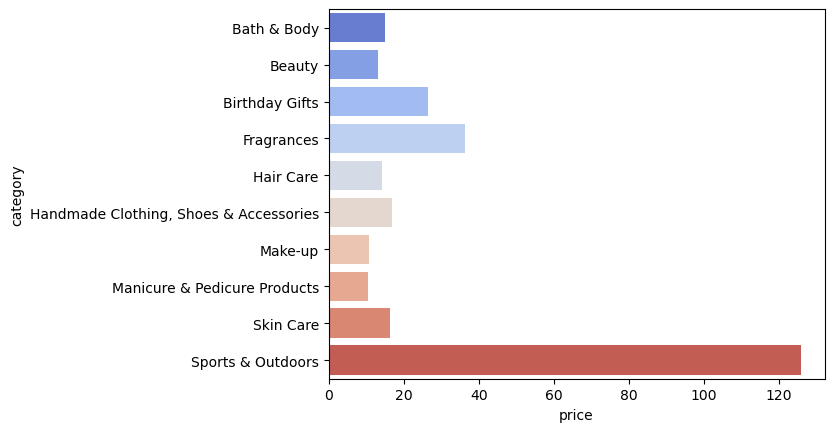

In [38]:
#Create a bar chart comparing the average price of products for the top 10 product categories (based on count). 
#Which product category commands the highest average price? Don't filter here by top categories.

# Filter top 10 categories based on count
top_10_categories = df['category'].value_counts().head(10).index
df_top_10 = df[df['category'].isin(top_10_categories)]

#Calculate Average Price
average_prices = df_top_10.groupby('category')['price'].mean().reset_index()

sns.barplot(data=average_prices, x='price', y='category', palette="coolwarm")

In [39]:
# Identify the category with the highest average price
highest_average_price_category = average_prices.idxmax()
highest_average_price_value = average_prices.max()

highest_average_price_category, highest_average_price_value

(category    9
 price       9
 dtype: int64,
 category    Sports & Outdoors
 price              125.769814
 dtype: object)

/var/folders/jg/z9vz0kpj1t56r_y5t2ghwzxc0000gn/T/ipykernel_61635/191911389.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_10, x='stars', y='category', palette="coolwarm")


<Axes: xlabel='stars', ylabel='category'>

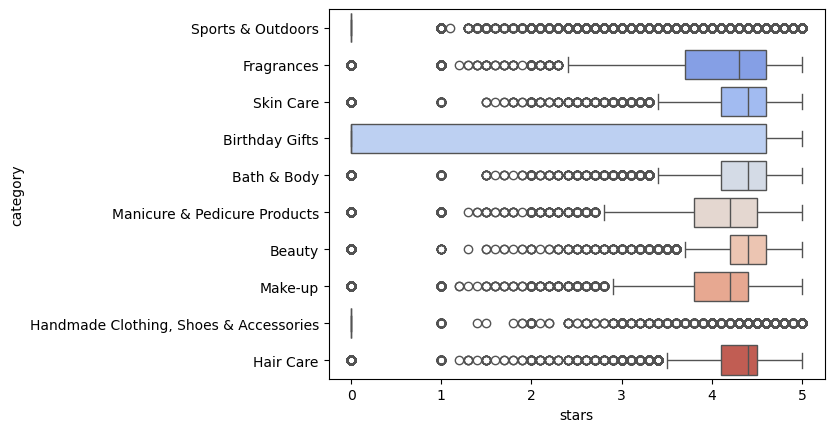

In [46]:
# Filter top 10 categories based on count
top_10_categories = df['category'].value_counts().head(10).index
df_top_10 = df[df['category'].isin(top_10_categories)]

sns.boxplot(data=df_top_10, x='stars', y='category', palette="coolwarm")

In [48]:
median_ratings = df.groupby('category')['stars'].median().sort_values(ascending=False)

print(median_ratings)

highest_median_ratings_category = median_ratings.idxmax()
highest_median_ratings_value = median_ratings.max()

highest_median_ratings_category, highest_median_ratings_value

category
Computer Memory                4.7
Hobbies                        4.6
Beer, Wine & Spirits           4.6
Laptop Accessories             4.6
Kids' Play Figures             4.6
                              ... 
KVM Switches                   0.0
Karaoke Equipment              0.0
Lab & Scientific Products      0.0
Laptops                        0.0
eBook Readers & Accessories    0.0
Name: stars, Length: 296, dtype: float64


('Computer Memory', 4.7)

## Part 3: Investigating the Interplay Between Product Prices and Ratings

Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

> Calculate the correlation coefficient between price and stars.

> Is there a significant correlation between product price and its rating?

Visualizations:

> Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

> Use a correlation heatmap to visualize correlations between all numerical variables.

> Examine if product prices typically follow a normal distribution using a QQ plot.

In [49]:
correlation = df['price'].corr(df['stars'])
correlation

-0.12490673262148681

In [50]:
#There isn't significant correlation between the price and ratings

<Axes: xlabel='stars', ylabel='price'>

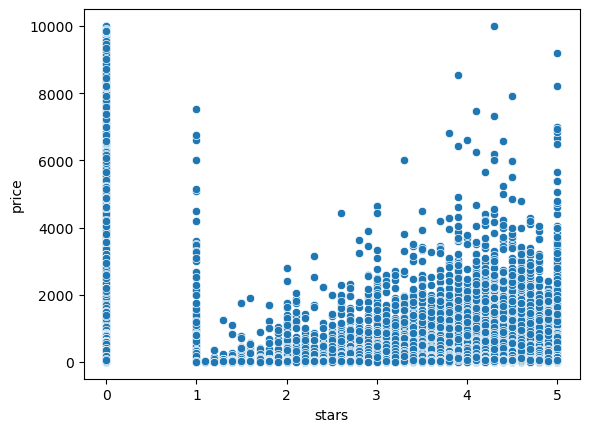

In [55]:
# Plotting a scatter plot to visualize the relationship (filter to only show certain prices)
df_filtered = df[(df['price'] <= 10000)]

sns.scatterplot(data=df_filtered, x='stars', y='price')

In [56]:
#The price of the product is not related to the ratings given; most are 0 (probably no reviews)
#The products with the most reviews are those that are less expensive

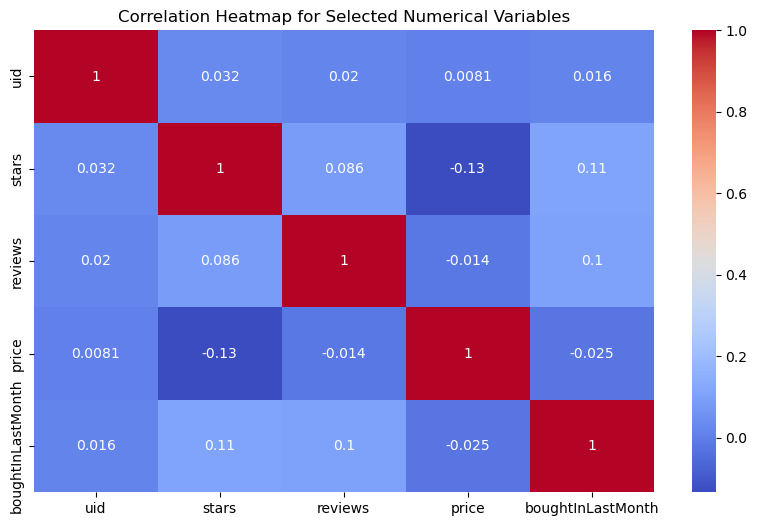

In [60]:
df_numerical = df_filtered.select_dtypes('number')

correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(10, 6))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

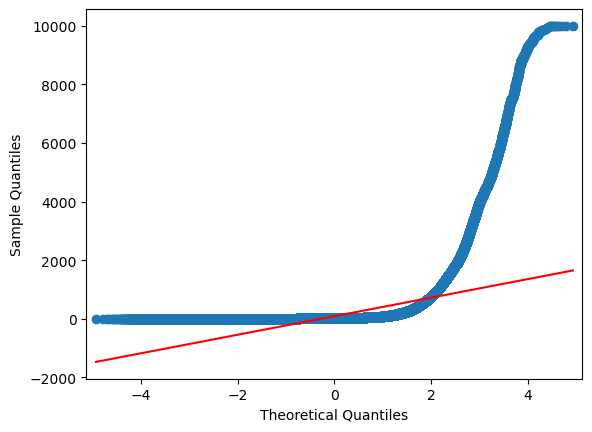

In [62]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'prices' to check if its distribution follows a normal distribution
sm.qqplot(df_filtered['price'], line='s');

In [63]:
#The product prices do not follow a normal distribution